In [1]:
import numpy as np

# dummy tensor field
# make tensor pointing vertically
up = np.array([[8,0,0],
              [0,1,0],
              [0,0,1]])

# make tensor pointing horizontally
right = np.array([[1,0,0],
              [0,8,0],
              [0,0,1]])

# identity
id = np.array([[1,0,0],
               [0,1,0],
               [0,0,1]])

# initialize tensor field
T = np.zeros((6,7,2,3,3))

T[1:3, 1:6, ...] = up
T[3:5, 1:6, ...] = right
T[:1,...] = id # pad the edges with the identity matrix
T[5:,...] = id
T[:,:1,...] = id
T[:,6:,...] = id


<IPython.core.display.Javascript object>


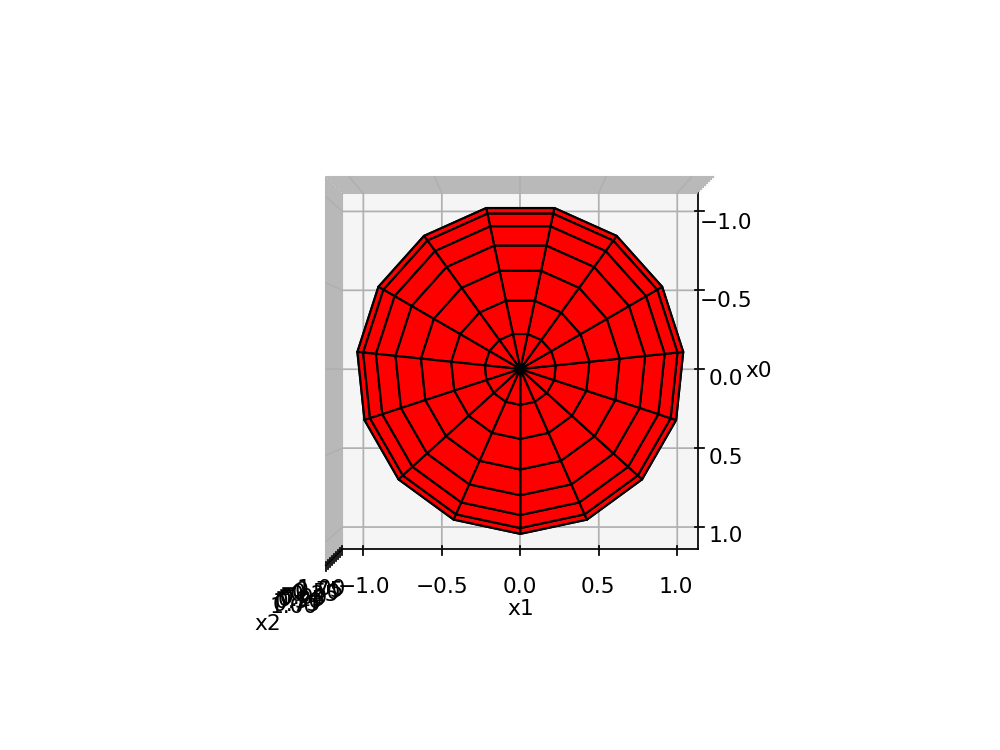

In [2]:
# now we have to draw ellipses
# first draw a square
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.linalg import sqrtm
f = plt.figure()
ax = f.add_subplot(projection='3d')
ax.view_init(elev=90,azim=0)

n0 = 15
n1 = 15
t0 = np.arange(n0+1)/n0 * 2.0*np.pi # alpha
t1 = np.arange(n1+1)/n1 * np.pi # polar
T0,T1 = np.meshgrid(t0,t1,indexing='ij')
Y0 = np.sin(T1)*np.cos(T0)
Y1 = np.sin(T1)*np.sin(T0)
Y2 = np.cos(T1)
#test
#################################################
# A12 = Q[3,1,0,...] @ T[3,1,0,...]# @ Q[3,1,0,...].T
# A12 = right
# Y0 = A12[0,0]*Y0 + A12[0,1]*Y1 + A12[0,2]*Y2
# Y1 = A12[1,0]*Y0 + A12[1,1]*Y1 + A12[1,2]*Y2
# Y2 = A12[2,0]*Y0 + A12[2,1]*Y1 + A12[2,2]*Y2
# ax.plot_surface(Y0,Y1,Y2,shade=False,color='r',edgecolor='k')
# ax.set_xlim(-8,8)
# ax.set_ylim(-8,8)
# ax.set_zlim(-8,8)
# ax.set_xlabel('x0')
# ax.set_ylabel('x1')
# ax.set_zlabel('x2')
#################################################
ax.plot_surface(Y0,Y1,Y2,shade=False,color='r',edgecolor='k')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

w,v = np.linalg.eigh(T)
trace = np.sum(w,-1)

R = T/np.trace(T,axis1=-1,axis2=-2)[...,None,None]
FA = np.sqrt(0.5*(3.0 - 1.0/np.trace(R@R,axis1=-1,axis2=-2)))
FA[np.isnan(FA)] = 0

In [6]:
# create grid
xI = []
for i in range(3):
    x = np.arange(T.shape[i]) - (T.shape[i]-1)/2
    xI.append(x)
X = np.stack(np.meshgrid(xI[0],xI[1],xI[2], indexing='ij'),axis=-1)

# make rotation matrices
theta = np.pi / 4
Rz = np.array([[np.cos(theta), -np.sin(theta), 0],
              [np.sin(theta), np.cos(theta), 0],
              [0,0,1]])
Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
              [0, 1, 0],
              [-np.sin(theta),0,np.cos(theta)]])
Rx = np.array([[1,0,0],
               [0, np.cos(theta), -np.sin(theta)],
               [0, np.sin(theta), np.cos(theta)]])

# rotate grid 45 degrees about z axis
dv = [1.,1.,1.]
Xrot = (Rz @ X[...,None])[...,0]#.transpose(3,0,1,2)

jacobian = lambda X,dv : np.stack(np.gradient(X, dv[0],dv[1],dv[2], axis=(0,1,2)), axis=-1)#.transpose(2,3,4,0,1)
J = jacobian(Xrot, dv)
Jinv = np.linalg.inv(J)
JinvT = Jinv.transpose(0,1,2,4,3)

In [8]:
print(Xrot.shape)

(6, 7, 2, 3)


<IPython.core.display.Javascript object>


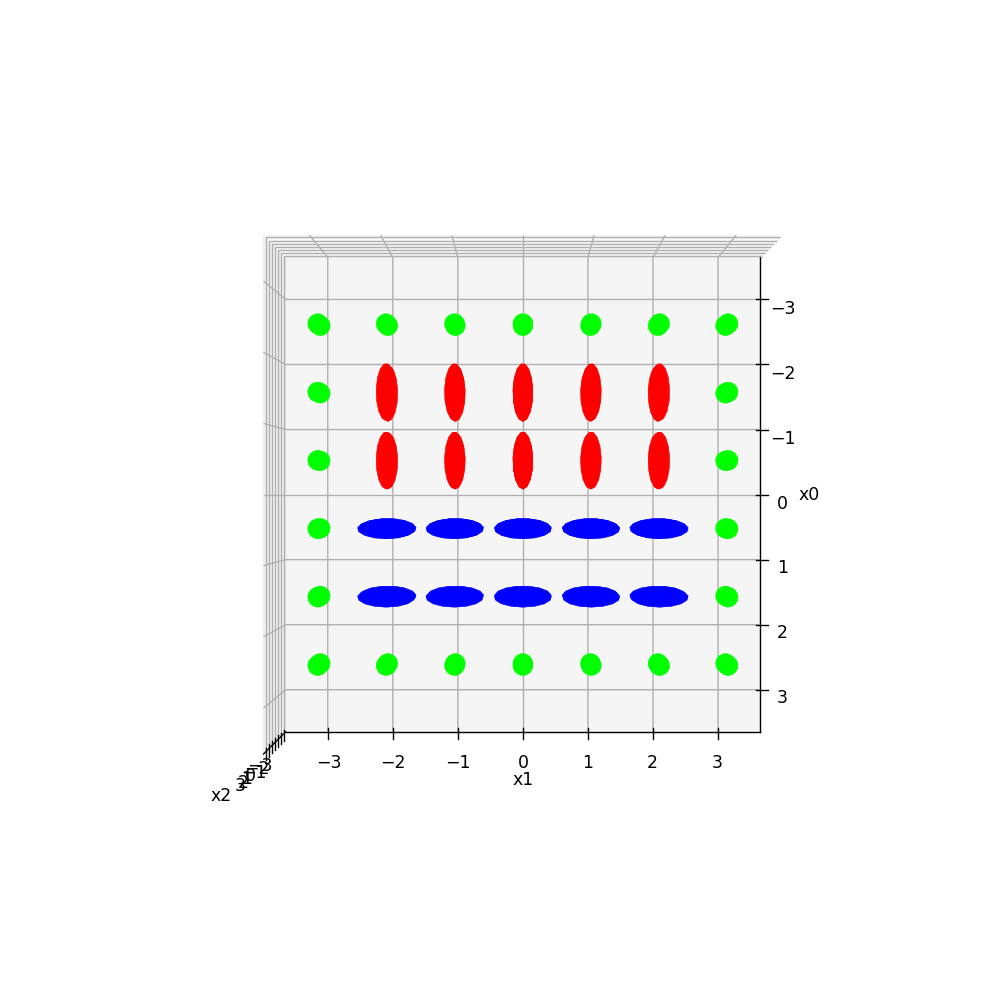

In [4]:
from matplotlib import cm

f = plt.figure(figsize=(8,8))
ax = f.add_subplot(projection='3d')
ax.view_init(elev=90,azim=0)

d = 1
for i in range(0,T.shape[0],d):
    for j in range(0,T.shape[1],d):
        for k in range(0,T.shape[2],d):
            A = T[i,j,k]
            A12 = sqrtm(A)
            Z0 = A12[0,0]*Y0 + A12[0,1]*Y1 + A12[0,2]*Y2
            Z1 = A12[1,0]*Y0 + A12[1,1]*Y1 + A12[1,2]*Y2
            Z2 = A12[2,0]*Y0 + A12[2,1]*Y1 + A12[2,2]*Y2
            scale = 0.15#*FA[i,j]        
            ax.plot_surface(scale*Z0+X[i,j,k,0],scale*Z1+X[i,j,k,1],scale*Z2+X[i,j,k,2],shade=False,color=np.abs(v[i,j,k,-2]),edgecolor=None)
            ax.set_xlim(-3.5,3.5)
            ax.set_ylim(-3.5,3.5)
            ax.set_zlim(-3.5,3.5)
            ax.set_xlabel('x0')
            ax.set_ylabel('x1')
            ax.set_zlabel('x2')

In [5]:
T.shape

(6, 7, 2, 3, 3)

In [5]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

tensors = T
# J = Jinv
# J = JinvT

# define function to construct rotation matrix from axis of rotation and angle
rot = lambda n, theta : np.array([[np.cos(theta)+n[...,0,None]**2*(1-np.cos(theta)), n[...,0,None]*n[...,1,None]*(1-np.cos(theta))-n[...,2,None]*np.sin(theta), n[...,0,None]*n[...,2,None]*(1-np.cos(theta))+n[...,1,None]*np.sin(theta)],
                                [n[...,0,None]*n[...,1,None]*(1-np.cos(theta))+n[...,2,None]*np.sin(theta), np.cos(theta)+n[...,1,None]**2*(1-np.cos(theta)), n[...,1,None]*n[...,2,None]*(1-np.cos(theta))-n[...,0,None]*np.sin(theta)],
                                [n[...,0,None]*n[...,2,None]*(1-np.cos(theta))-n[...,1,None]*np.sin(theta), n[...,1,None]*n[...,2,None]*(1-np.cos(theta))+n[...,0,None]*np.sin(theta), np.cos(theta)+n[...,2,None]**2*(1-np.cos(theta))]]).squeeze().transpose(2,3,4,0,1)

# compute unit eigenvectors, e, of tensors
w,e = np.linalg.eigh(tensors)
e1 = e[...,-1]
e2 = e[...,-2]
# compute unit vectors n1 and n2 in the directions of J@e1 and J@e2
Je1 = np.squeeze(J @ e1[...,None])
n1 = Je1 / np.linalg.norm(Je1, axis=-1)[...,None]
Je2 = np.squeeze(J @ e2[...,None])
n2 = Je2 / np.linalg.norm(Je2, axis=-1)[...,None]
# compute a rotation matrix, R1, that maps e1 onto n1
theta = np.arccos(np.squeeze(e1[..., None, :] @ n1[..., None]))[...,None]
r = np.cross(e1,n1) / np.sin(theta)
# r will be nan wherever e1 and n1 align, i.e. where Je1 == e1. NOTE: Divide by zero warning is suppressed
# replace r whereever there are nans with a different r. I use n2 instead of n1.
theta2 = np.arccos(np.squeeze(e1[..., None, :] @ n2[..., None]))[...,None]
r2 = np.cross(e1,n2) / np.sin(theta2)
r[np.isnan(r)] = r2[np.isnan(r)]
# theta[np.where(theta==0)] = theta2[np.where(theta==0)]
R1 = rot(r,theta)
# compute a secondary rotation, about n1, to map e2 from its position after the first rotation, R1 @ e2,
# to the n1-n2 plane.
Pn2 = n2 - (n2[..., None, :] @ n1[..., None])[...,0] * n1
Pn2 = Pn2 / np.linalg.norm(Pn2, axis=-1)[...,None]
R1e1 = np.squeeze(R1 @ e1[...,None])
R1e2 = np.squeeze(R1 @ e2[...,None])
phi = np.arccos(np.squeeze(R1e2[..., None, :] @ Pn2[..., None]) / (np.linalg.norm(R1e2) * np.linalg.norm(Pn2)))[...,None]
R2 = rot(R1e1, phi)

Q = R2 @ R1

In [6]:
Trot = Q @ T @ Q.transpose(0,1,2,4,3)

<IPython.core.display.Javascript object>


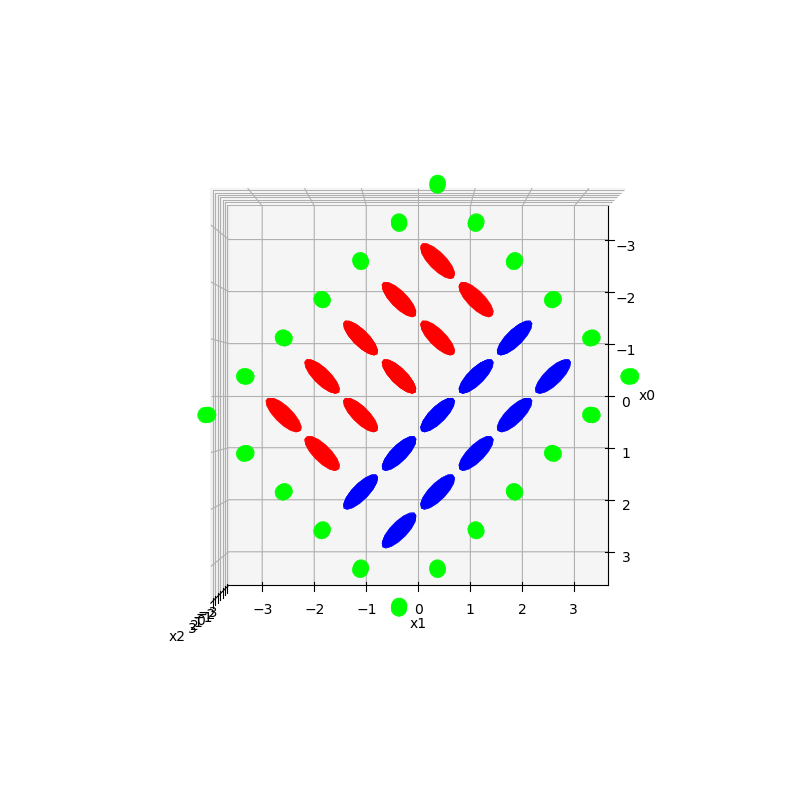

In [7]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(projection='3d')
ax.view_init(elev=90,azim=0)

d = 1
for i in range(0,Trot.shape[0],d):
    for j in range(0,Trot.shape[1],d):
        for k in range(0,Trot.shape[2],d):
            A = Trot[i,j,k]
            A12 = sqrtm(A)
            Z0 = A12[0,0]*Y0 + A12[0,1]*Y1 + A12[0,2]*Y2
            Z1 = A12[1,0]*Y0 + A12[1,1]*Y1 + A12[1,2]*Y2
            Z2 = A12[2,0]*Y0 + A12[2,1]*Y1 + A12[2,2]*Y2
            scale = 0.15#*FA[i,j]        
            ax.plot_surface(scale*Z0+Xrot[i,j,k,0],scale*Z1+Xrot[i,j,k,1],scale*Z2+Xrot[i,j,k,2],shade=False,color=np.abs(v[i,j,k,-2]),edgecolor=None)
            ax.set_xlim(-3.5,3.5)
            ax.set_ylim(-3.5,3.5)
            ax.set_zlim(-3.5,3.5)
            ax.set_xlabel('x0')
            ax.set_ylabel('x1')
            ax.set_zlabel('x2')

In [78]:
import numpy as np
import sympy
from sympy import init_printing
init_printing() 
from sympy import Ynm, Ynm_c, Znm, Symbol, diff, integrate
from sympy.abc import n,m
theta = Symbol("theta")
phi = Symbol("phi")
from sympy import pretty

In [166]:
Ynm(1,-1,theta,phi).expand(func=True)

In [181]:
import time
start = time.time()
for i in range(100):
    e = sympy.im(Ynm(1,-1,theta,phi).expand(func=True))
    f = e.evalf(subs={theta:0.7,phi:0.7})
stop = time.time()
print(f'elapsed: {stop-start}')

elapsed: 0.04381966590881348


In [182]:
start = time.time()
for i in range(100):
    a = (Znm(1,-1,theta,phi) - Ynm_c(1,-1,theta,phi))
    b = sympy.im(a.evalf(subs={theta:0.7,phi:0.7}))
stop = time.time()
print(f'elapsed: {stop-start}')

elapsed: 0.657196044921875


In [171]:
f = e.evalf(subs={theta:0.7,phi:0.7})
b = a.evalf(subs={theta:0.7,phi:0.7})

In [173]:
f

In [176]:
f==sympy.im(b)

True

In [211]:
n = 14
i = 0
for n in np.arange(n+1, step=2):
    for m in np.arange(-n,n+1):
#         print(n,m)
        i += 1
print(i)

120


In [194]:
Yphi = []
n = 8
for n in np.arange(n+1, step=2):
    for m in np.arange(-n,n+1):
        print(n,m)
        if m < 0:
            Yphi.append(sympy.sqrt(2)*sympy.re(integrate(Ynm(n,m,theta,phi).expand(func=True),(theta,0,sympy.pi))))
        elif m == 0:
            Yphi.append(integrate(Ynm(n,m,theta,phi).expand(func=True),(theta,0,sympy.pi)))
        elif m > 0:
            Yphi.append(sympy.sqrt(2)*sympy.im(integrate(Ynm(n,m,theta,phi).expand(func=True),(theta,0,sympy.pi))))


0 0
2 -2
2 -1
2 0
2 1
2 2
4 -4
4 -3
4 -2
4 -1
4 0
4 1
4 2
4 3
4 4
6 -6
6 -5
6 -4
6 -3
6 -2
6 -1
6 0
6 1
6 2
6 3
6 4
6 5
6 6
8 -8
8 -7
8 -6
8 -5
8 -4
8 -3
8 -2
8 -1
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8


In [195]:
Nphi = 10
Y_sampled = np.zeros((Nphi,len(Yphi)))
for t in range(Nphi):
    for i,y in enumerate(Yphi):
        x = t*Nphi/np.pi
        Y_sampled[t,i] = float(y.evalf(subs={phi:x}))
    

In [213]:
Y_sampled.shape

In [94]:
JY11 = (Znm(1,1,theta,phi) - Ynm_c(1,1,theta,phi)).expand(func=True)
JY11

-sqrt(3)*exp(I*phi)*sin(theta)/(4*sqrt(pi)) - sqrt(3)*exp(-I*phi)*sin(theta)/(4*sqrt(pi)) + sqrt(6)*exp(-I*phi)*sin(theta)/(4*sqrt(pi))

In [95]:
int_JY11 = integrate(JY11,(theta,0,sympy.pi))#.simplify(func=True)
int_JY11

(-16*sqrt(3)*pi**(3/2)*exp(3*I*phi) - 16*sqrt(3)*pi**(3/2)*exp(I*phi) + 16*sqrt(6)*pi**(3/2)*exp(I*phi))*exp(-2*I*phi)/(64*pi**2) - (16*sqrt(3)*pi**(3/2)*exp(3*I*phi) - 16*sqrt(6)*pi**(3/2)*exp(I*phi) + 16*sqrt(3)*pi**(3/2)*exp(I*phi))*exp(-2*I*phi)/(64*pi**2)

In [78]:
x = Symbol("x")
y = Symbol("y")
expr = x**2 + x + 1
expr_int = integrate(expr,x)
expr_int


x**3/3 + x**2/2 + x

In [214]:
A = np.zeros((3,4,5))
A.moveaxis(0,-1)

AttributeError: 'numpy.ndarray' object has no attribute 'moveaxis'

In [65]:
%matplotlib notebook
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [86]:
with h5py.File('/home/brysongray/donglab/bk_sta_outputs/SF220817_01A_01_01_10x_BF_02_S.h5', 'r') as f:
    S = f['S'][:]

In [87]:
S[3500,4500]

array([[0.00685687, 0.00845227],
       [0.00845227, 0.01222478]])

In [88]:
w,v = np.linalg.eigh(S)

<IPython.core.display.Javascript object>


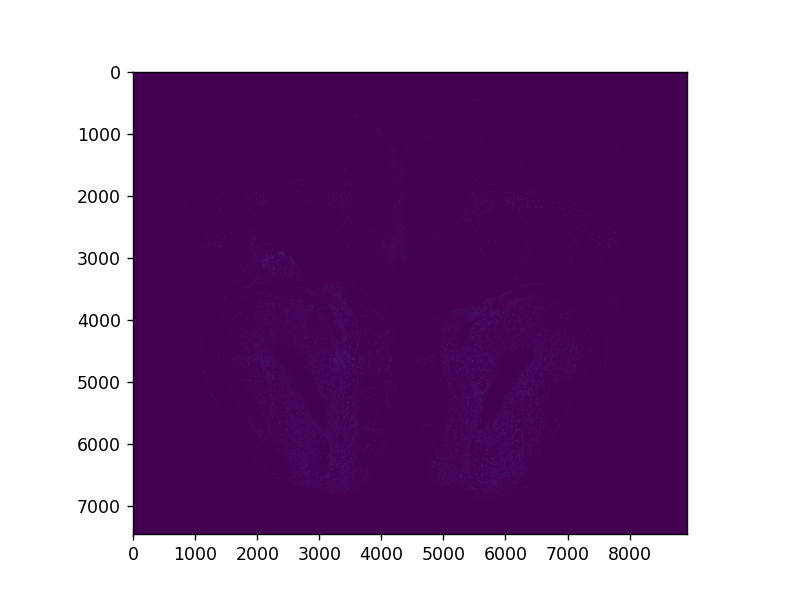

In [89]:
plt.figure()
plt.imshow(w[...,0])

<IPython.core.display.Javascript object>


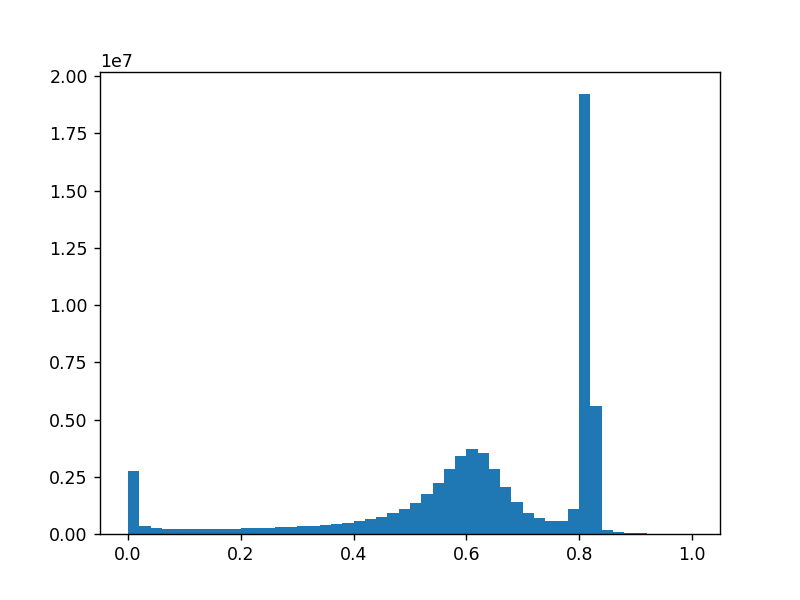

(array([2.7527870e+06, 3.4103200e+05, 2.4181300e+05, 2.1314000e+05,
        2.0105800e+05, 2.0339200e+05, 2.0779400e+05, 2.1629300e+05,
        2.2724400e+05, 2.3773700e+05, 2.5029300e+05, 2.6337200e+05,
        2.7769200e+05, 2.9535700e+05, 3.1684700e+05, 3.4003500e+05,
        3.6791500e+05, 4.0196500e+05, 4.4309300e+05, 4.9460900e+05,
        5.6099100e+05, 6.4386400e+05, 7.5543200e+05, 9.0130600e+05,
        1.1005870e+06, 1.3729440e+06, 1.7439760e+06, 2.2435280e+06,
        2.8482140e+06, 3.4242180e+06, 3.7236800e+06, 3.5161630e+06,
        2.8591520e+06, 2.0610000e+06, 1.3848740e+06, 9.3335200e+05,
        6.8179200e+05, 5.6738700e+05, 5.6028700e+05, 1.0897530e+06,
        1.9214024e+07, 5.5971290e+06, 1.7245500e+05, 9.1744000e+04,
        4.9091000e+04, 2.5962000e+04, 1.3166000e+04, 6.4680000e+03,
        2.5400000e+03, 6.3300000e+02]),
 array([5.31092613e-04, 2.05080033e-02, 4.04849139e-02, 6.04618246e-02,
        8.04387352e-02, 1.00415646e-01, 1.20392556e-01, 1.40369467e-01,


In [73]:
plt.figure()
plt.hist(e[...,1].flatten(), 50)

In [90]:
AI = abs(w[...,0] - w[...,1]) / abs(w[...,0] + w[...,1])

<IPython.core.display.Javascript object>


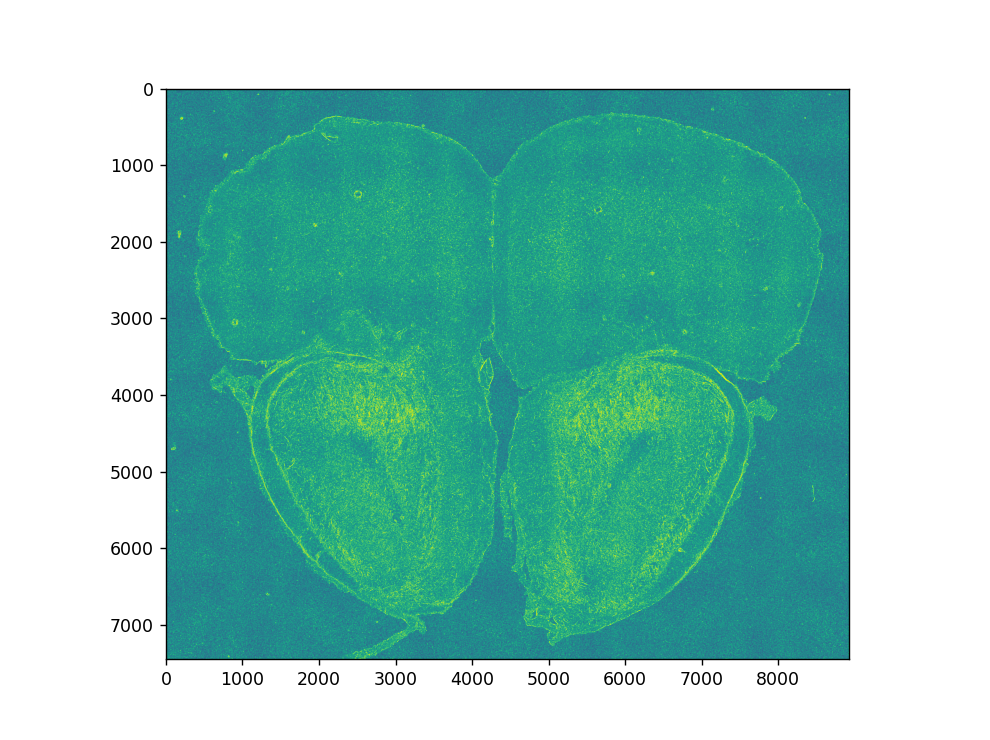

In [91]:
plt.figure()
plt.imshow(AI)

In [239]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from fury import actor, window
from IPython.core.display import Image
from PIL import Image as PILImage
import numpy as np
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
from dipy.core.gradients import gradient_table
import time
from scipy.spatial import SphericalVoronoi

In [211]:
n_pts = 100
bvalue = 1000
np.random.seed(0)
theta = np.pi - np.random.rand(n_pts)
phi = 2 * np.pi - np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)

iterations: 12
time: 0.0341339111328125
delta: 0.0
potential: 36910.26601605613


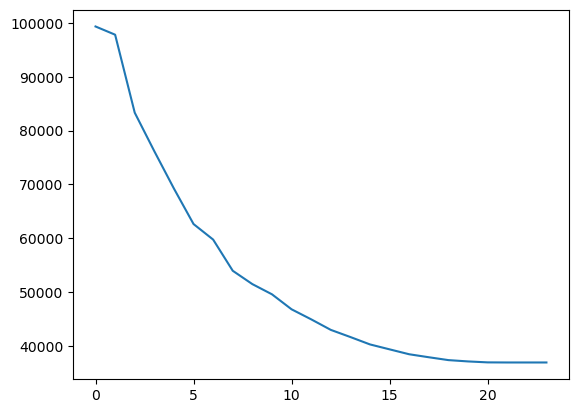

In [220]:
it = 1
start = time.time()
hsph_updated, potential = disperse_charges(hsph_initial,2, const=0.5)
while np.abs(potential[-2]-potential[-1]) > 1:
    hsph_updated, pot = disperse_charges(hsph_updated,2, const=0.5)
    potential = np.append(potential,pot)
    it += 1
stop = time.time()
print(f"iterations: {it}")
print(f"time: {stop-start}")
print(f"delta: {np.abs(potential[-2]-potential[-1])}")
print(f"potential: {potential[-1]}")

plt.figure()
plt.plot(potential)

vertices = hsph_updated.vertices
values = np.ones(vertices.shape[0])
bvecs = np.vstack((vertices))
bvals = np.hstack((bvalue * values))
# add some b=0 bvals/bvecs
bvecs = np.insert(bvecs, (0,bvecs.shape[0]), np.array([0,0,0]), axis = 0)
bvals = np.insert(bvals, (0, bvals.shape[0]), 0)

gtab = gradient_table(bvals, bvecs)
sph_gtab = Sphere(xyz=np.vstack((vertices,-vertices)))

delta: 0.5624540124190389
time: 0.10355520248413086
potential: 36913.26329751137


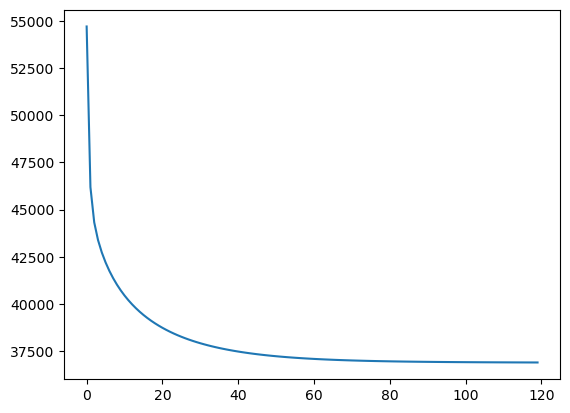

In [218]:
start = time.time()
hsph_updated, potential = disperse_charges(hsph_initial,120, const=100)
stop = time.time()
print(f"delta: {potential[-2] - potential[-1]}")
print(f"time: {stop-start}")
print(f"potential: {potential[-1]}")

plt.figure()
plt.plot(potential)

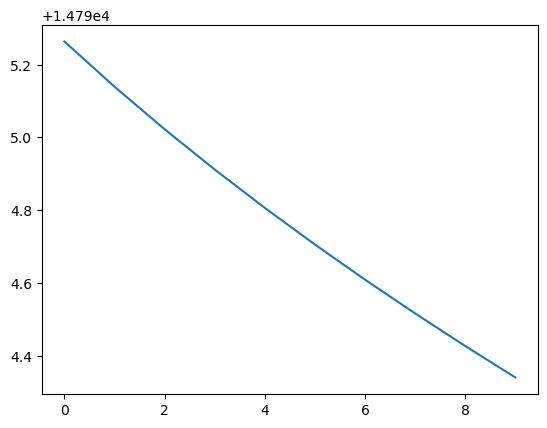

In [140]:
plt.figure()
plt.plot(potential[-10:])

In [18]:
WINDOW_SIZE = (400, 400)
SAVEIM_FOLDER = 'images'
if not os.path.exists(SAVEIM_FOLDER):
    os.mkdir(SAVEIM_FOLDER)
def screenshot_gradients(sph_gtab, title='Modeling'):
    scene = window.Scene()
    scene.background(window.colors.white)

    scene.add(actor.point(sph_gtab.vertices, window.colors.green, point_radius=0.05))

    outfile = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, size=WINDOW_SIZE, fname=outfile)

    scene.clear()
    return outfile

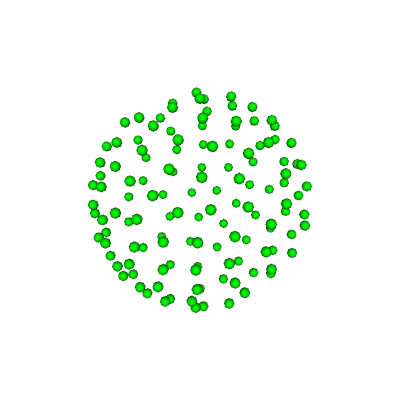

In [221]:
image = screenshot_gradients(sph_gtab, title='Example directions')
Image(filename=image)

In [224]:
dir(sph_gtab)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'edges',
 'faces',
 'find_closest',
 'phi',
 'subdivide',
 'theta',
 'vertices',
 'x',
 'y',
 'z']

In [232]:
A = np.array([[0,0,1],[0,1,0],[1,0,0]])
sph_gtab.find_closest(A)

234

In [237]:
sph_gtab.vertices.shape

(200, 3)

In [240]:
sv = SphericalVoronoi(sph_gtab.vertices)

In [241]:
dir(sv)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calc_vertices_regions',
 '_calculate_areas_2d',
 '_calculate_areas_3d',
 '_dim',
 '_rank',
 '_simplices',
 'calculate_areas',
 'center',
 'points',
 'radius',
 'regions',
 'sort_vertices_of_regions',
 'vertices']

In [243]:
sv.sort_vertices_of_regions()

In [244]:
sv.vertices

array([[ 0.58931288, -0.43259118,  0.68233071],
       [ 0.13075572, -0.94614037,  0.2961779 ],
       [ 0.05684791, -0.8964112 ,  0.4395626 ],
       ...,
       [ 0.04460558,  0.99899815, -0.00361007],
       [ 0.09243975,  0.97718354, -0.1912256 ],
       [ 0.17685863,  0.95722891, -0.22898437]])